In [3]:
import os

import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA

from sklearn.ensemble import RandomForestRegressor

import xgboost as xgb

from matplotlib import pyplot as plt
import seaborn as sns
from graphviz import Digraph

/var/folders/y6/pdkrkx0s06d2k0_qhmmrpf8c0000gn/T/ipykernel_49817/1892926597.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


XGBoost is a type of boosting system that uses Tree Boosting algorithm to build ML models. It is one of the most widely used models, especially in the domain of High Energy Physics (HEP). The original paper was published in 2016 (https://arxiv.org/pdf/1603.02754.pdf) descibes a sparsity-aware algorithm for sparse data and weighted quantile sketch for approximate tree learning. It also describes other aspects related to achieving sclable learning such as out-of-core computation, cache-awareness and sparsity-awareness.

To train the model, we start by defining an objective function, which is similar to the standard Langrangian used in physics. The objective function can be defined in two parts as below:

$$\mathcal{L}(\phi) =  \sum_{i}l(\hat{y_i}, y_i)+\sum_{k} \Omega(f_k)$$

where

$$\Omega(f) = \gamma T+\dfrac{1}{2}\lambda\left \| w \right \|^2$$

$l$ is the  differentiable convex loss function, which computes the "error" for each data point and the second term is the **regularization** that adds a penalty to prevent overtraining at eah step of the iteration. The **regularization** terms include two tunable multiplier terms $\lambda$ and $\gamma$, which penalize for number of leaves used ($T$) in a tree and the weights ($w$) assigned to each of those leaves respectively.

Let's start by define a class for training the data using Gradient Boosting. Gradient Boost starts by making a single leaf which is the predictor of the average value of y. Then, it calculates residuals for each entry in the training dataset. Then the algorithm build a binary tree where each node sorts the dataset using a criterion. The trees will grow until they reach the specified maximum depth (`maxdepth`). Hence, a tree classifies the entire dataset into several categories depending on the values of the features. Depending on which category the data point enters, it's residual is recalculated. This processed is repeated for a number of times equal to the `n_estimators` specified leading to a lesser residual at every step. In this example, we are using `squarederror` as the objective function.

In [4]:
class CDMSXGBRegressor:
    """
    A class to train a XGBoost Regressor on the CDMS dataset. The training can be done with either cross-validation method, 
    in which case the entire dataset is randomly divided into `train` and `test` sets. Or the training can be done using
    hold-out-dataset method, in which case the dataset will be grouped by the speicified target values into `train` and `test` sets.
    ...

    Attributes
    ----------
    holdout : bool
        Whether to use holdout method or not
    kcv : int
        Number of sets in k-fold cross-validation
    scaler : StandardScaler
        Scaler to normalize the dataset
    xgb_regressors : list
        List of trained XGBoost Regressors. For cross-validation the list will be of size kcv.
    df : pd.DataFrame
        Input dataset
    X:  Numpy Array
        Processed input dataset
    Y:  Numpy Array
        Target values
    
    Methods
    ----------
    read_dataset(filename, custom_features=None, drop_features=None, HOS=None, cv=False)
        Read the dataset from the specified file
    preprocess_dataset()
        Preprocess the dataset
    initialize_xgboost_regressor()
        Initialize XGBoost Regressor
    train_xgboost_regressor()
        Train XGBoost Regressor

    """
    def __init__(self):
        
        self.holdout = False
        self.kcv = 1
        
        self.scaler = StandardScaler()
        self.xgb_regressors = []
        
        self.df = None
        self.X = None
        self.Y = None
        
    
    def read_dataset(self,
                     filename,
                     custom_features=None,
                     drop_features=None,
                     HOS=None,
                     kcv=1):
        """
        Parameters
        ----------
        filename: str
            name of the file
        custom_features: list
            list of columns to be used as features
        drop_features: list
            list of columns to be dropped (WARNING: cannot be used with custom_features together)
        HOS: list
            list of target values to be used as hold-out-dataset
        cv: int
            number of sets in k-fold cross-validation (WARNING: cannot be used with HOS together)
        Returns
        ----------
        bool
            whether the dataset was read successfully or not. If not, the program will exit.
        ...
        Examples
        ----------
        >>> cdms_xgb_regressor.read_dataset('data/cdms-dataset.csv')
        >>> cdms_xgb_regressor.read_dataset('data/cdms-dataset.csv', custom_features=['x1', 'x2', 'x3'])
        >>> cdms_xgb_regressor.read_dataset('data/cdms-dataset.csv', drop_features=['x1', 'x2', 'x3'])
        >>> cdms_xgb_regressor.read_dataset('data/cdms-dataset.csv', HOS=[-41.9])
        """
        self.df = pd.read_csv(filename)
        self.df = self.df.sample(frac=1).reset_index(drop=True) # randomize the dataset

        # generate cv set
        self.df = pd.read_csv(filename)
        self.df = self.df.sample(frac=1).reset_index(drop=True) # randomize the dataset
        
        # generate cv set
        dsize = len(self.df)
        self.kcv = kcv
        if self.kcv: self.df['cv'] = np.array(np.random.rand(dsize)*self.kcv, dtype=int)
        else: self.df['cv'] = np.zeros(dsize)
        self.df['HOS'] = False

        # filter out columns
        if custom_features and drop_features:
            print('Warning: You can use only one of custom_features or drop_features')
            return False
        
        # use custom selection of columns
        if custom_features is not None:
            self.df = self.df[custom_features]
        elif drop_features is not None:
            self.df = self.df.drop(drop_features, axis=1)
        else:
            self.df = self.df.drop(['Row'], axis=1)

        if HOS is not None:
            self.holdout = True
            self.df['HOS'] = self.df['y'].apply(lambda x: True if x in HOS else False)
            self.df = self.df.sample(frac=1).reset_index(drop=True)

        return True
    
    def preprocess_dataset(self):
        """
        normalize dataset using standard scaler
        """
        self.X = self.df.drop(['cv','y','HOS'], axis=1).to_numpy()
        self.X = self.scaler.fit_transform(self.X)
        self.Y = self.df['y'].to_numpy()

    
    def initialize_xgb_regressors(self, params):
        
        if self.holdout:
            xgb_regressor = xgb.XGBRegressor(**params)
            self.xgb_regressors.append(xgb_regressor)
        
        else:
            for i in range(self.kcv):
                xgb_regressor = xgb.XGBRegressor(**params)
                self.xgb_regressors.append(xgb_regressor)
        
    def train_regressors(self, path_to_output='../training/test'):
        """
        Parameters
        ----------
        path_to_output: str
            path to the directory where the trained model will be saved
        Outputs
        ----------
        bool
            whether the model was trained successfully or not. If not, the program will exit.
        ...
        Examples
        ----------
        >>> cdms_xgb_regressor.train_regressors()
        >>> cdms_xgb_regressor.train_regressors(path_to_output='../training/test')
        >>> cdms_xgb_regressor.train_regressors(path_to_output='../training/test', params={'max_depth':2})
        """

        if not os.path.exists(path_to_output):
            os.makedirs(path_to_output)
        else:
            print('Warning: directory already exists.')
            return False
        
        dsize = len(self.df)
        print('Training regressors...')
        
        if self.holdout:
            xgb_ = self.xgb_regressors[0]
            X_ = self.X[self.df['HOS']==False]
            Y_ = self.Y[self.df['HOS']==False]
            X_test = self.X[self.df['HOS']==True]
            Y_test = self.Y[self.df['HOS']==True]

            X_train, X_val, Y_train, Y_val = train_test_split(X_, Y_, test_size=0.33, random_state=7)
            xgb_.fit(X_train, Y_train, eval_set = [(X_train, Y_train), (X_val, Y_val)], eval_metric='rmse', early_stopping_rounds=10, verbose=True)
            results = xgb_.evals_result()
            
            epochs = len(results['validation_0']['rmse'])
            erange = range(0, epochs)
            fig, ax = plt.subplots()
            ax.plot(erange, results['validation_0']['rmse'], label='Train')
            ax.plot(erange, results['validation_1']['rmse'], label='Validation')
            ax.legend()
            plt.ylabel('RMSE')
            plt.title('XGBoost RMSE')
            plt.savefig(path_to_output+'/xgb_rmse.png')

            rmse = np.std(xgb_.predict(X_train)-Y_train)
            print('Train RMSE: ', rmse)
            rmse = np.std(xgb_.predict(X_val)-Y_val)
            print('Validation RMSE: ', rmse)
            rmse = np.std(xgb_.predict(X_test)-Y_test)
            print('Test RMSE: ', rmse)
            # initialize a vector for storing predictions
        
        else:
            if self.kcv>1:
                for i in range(self.kcv):
                    xgb_ = self.xgb_regressors[i]
                    X_train = self.X[self.df['cv']!=i]
                    Y_train = self.Y[self.df['cv']!=i]
                    X_test = self.X[self.df['cv']==i]
                    Y_test = self.Y[self.df['cv']==i]
                    xgb_.fit(X_train, Y_train)

                    rmse = np.std(xgb_.predict(X_train)-Y_train)
                    print('Train RMSE: ', rmse)
                    rmse = np.std(xgb_.predict(X_test)-Y_test)
                    print('Test RMSE: ', rmse)
            else:
                xgb_ = self.xgb_regressors[0]
                
                X_train, X_val, Y_train, Y_val = train_test_split(self.X, self.Y, test_size=0.33, random_state=7)
                xgb_.fit(X_train, Y_train, eval_set = [(X_train, Y_train), (X_val, Y_val)], eval_metric='rmse', early_stopping_rounds=5, verbose=True)
                results = xgb_.evals_result()
                
                epochs = len(results['validation_0']['rmse'])
                erange = range(0, epochs)
                fig, ax = plt.subplots()
                ax.plot(erange, results['validation_0']['rmse'], label='Train')
                ax.plot(erange, results['validation_1']['rmse'], label='Validation')
                ax.legend()
                plt.ylabel('RMSE')
                plt.title('XGBoost RMSE')
                plt.savefig(path_to_output+'/xgb_rmse.png')

                rmse = np.std(xgb_.predict(X_train)-Y_train)
                print('Train RMSE: ', rmse)
                rmse = np.std(xgb_.predict(X_val)-Y_val)
                print('Validation RMSE: ', rmse)
        
        nreg = len(self.xgb_regressors)
        for i in range(nreg):
            self.xgb_regressors[i].save_model(path_to_output+'/xgb_regressor_'+str(i)+'.json')
    
    def get_predictions(self, path_to_output):
        """
        Parameters
        ----------
        filename: str
            name of the file where the predictions will be saved
        Outputs
        ----------
        bool
            whether the predictions were saved successfully or not. If not, the program will exit.
        ...
        Examples
        ----------
        >>> cdms_xgb_regressor.get_predictions('data/cdms-predictions.csv')
        """
        
        if self.holdout:
            self.df['predictions'] = self.xgb_regressors[0].predict(self.X)
        else:
            self.df['predictions'] = np.zeros(len(self.df))
            for i in range(self.kcv):
                self.df['predictions'] += (self.xgb_regressors[i].predict(self.X))*(self.df['cv']==i)

        self.df['predictions'].to_csv(path_to_output+'/predictions.csv', index=False)

Now, let's proceed to training the XGBoost model. First, we need to make a dictionary to fix different training parameters within the model.

   * n_estimators     – Number of gradient boosted trees. Equivalent to number of boosting rounds. Set it to 100.
   * max_depth        – Maximum tree depth for base learners. Set it to 6.
   * learning_rate    – Boosting learning rate (xgb’s “eta”). Set it to 0.3.
   * objective        – Objective function for training. In this example, we will use RMSE.
   * booster          - Use gbtree
   * tree_method      – Set split-finding method to exact.
   * gamma            – (min_split_loss) Minimum loss reduction required to make a further partition on a leaf node of the tree. Set it to 0.
   * min_child_weight – Minimum sum of instance weight(hessian) needed in a child.
   * max_delta_step   – Maximum delta step we allow each tree’s weight estimation to be.
   * reg_alpha        - L1 resularization term. Set it to 0.
   * reg_lambda       - L2 resularization term. Set it to 0.

Training regressors...
[0]	validation_0-rmse:18.40265	validation_1-rmse:18.52068
[1]	validation_0-rmse:12.88326	validation_1-rmse:12.97162
[2]	validation_0-rmse:9.01981	validation_1-rmse:9.08941
[3]	validation_0-rmse:6.31585	validation_1-rmse:6.37601
[4]	validation_0-rmse:4.42307	validation_1-rmse:4.48372
[5]	validation_0-rmse:3.09878	validation_1-rmse:3.16640
[6]	validation_0-rmse:2.17179	validation_1-rmse:2.25775
[7]	validation_0-rmse:1.52345	validation_1-rmse:1.63635
[8]	validation_0-rmse:1.07048	validation_1-rmse:1.22056
[9]	validation_0-rmse:0.75388	validation_1-rmse:0.95305
[10]	validation_0-rmse:0.53284	validation_1-rmse:0.78740
[11]	validation_0-rmse:0.37993	validation_1-rmse:0.69201
[12]	validation_0-rmse:0.27305	validation_1-rmse:0.64057
[13]	validation_0-rmse:0.20009	validation_1-rmse:0.61295
[14]	validation_0-rmse:0.15111	validation_1-rmse:0.59779


/opt/homebrew/anaconda3/envs/tf-metal/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/opt/homebrew/anaconda3/envs/tf-metal/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/homebrew/anaconda3/envs/tf-metal/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:54:01] WARNING: /Users/runner/work/xgboost/xgboost/src/common/error_msg.cc:45: `gpu_id` is deprecated since2.0.0, use `device` instead. E.g. device=cpu/cuda/cuda:0
  warnings.warn(smsg, UserWarning)


[15]	validation_0-rmse:0.11725	validation_1-rmse:0.59002
[16]	validation_0-rmse:0.09463	validation_1-rmse:0.58579
[17]	validation_0-rmse:0.08159	validation_1-rmse:0.58349
[18]	validation_0-rmse:0.07192	validation_1-rmse:0.58209
[19]	validation_0-rmse:0.06722	validation_1-rmse:0.58112
[20]	validation_0-rmse:0.06056	validation_1-rmse:0.58052
[21]	validation_0-rmse:0.05607	validation_1-rmse:0.58027
[22]	validation_0-rmse:0.05355	validation_1-rmse:0.57957
[23]	validation_0-rmse:0.04935	validation_1-rmse:0.57946
[24]	validation_0-rmse:0.04745	validation_1-rmse:0.57869
[25]	validation_0-rmse:0.04655	validation_1-rmse:0.57879
[26]	validation_0-rmse:0.04511	validation_1-rmse:0.57925
[27]	validation_0-rmse:0.04339	validation_1-rmse:0.57982
[28]	validation_0-rmse:0.04024	validation_1-rmse:0.57986
[29]	validation_0-rmse:0.03990	validation_1-rmse:0.57957
Train RMSE:  0.047357607760099986
Validation RMSE:  0.5786913680663924


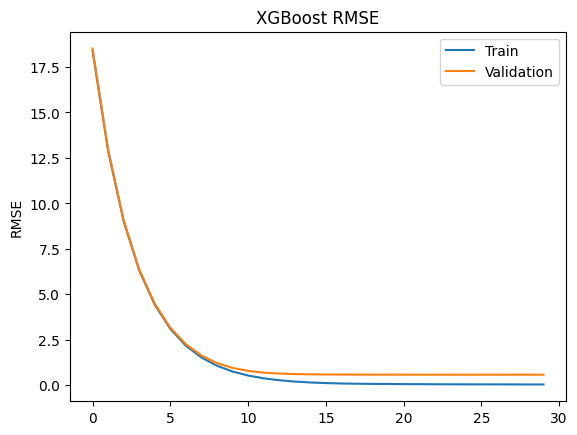

In [6]:
param = {
'base_score':0.5, 'booster':'gbtree', 'colsample_bylevel':1,
'colsample_bynode':1, 'colsample_bytree':1, 'gamma':0, 'gpu_id':-1,
'importance_type':'gain', 'interaction_constraints':'',
'learning_rate':0.3, 'max_delta_step':0, 'max_depth':6,
'min_child_weight':1, 'monotone_constraints':(),
'n_estimators':100, 'n_jobs':0, 'num_parallel_tree':1, 'random_state':0,
'reg_alpha':0, 'reg_lambda':0, 'scale_pos_weight':1, 'subsample':1,
'tree_method':'exact', 'validate_parameters':1, 'verbosity':None
}

output_folder = '../training/xgb_no_cv/'

xr = CDMSXGBRegressor()
xr.read_dataset('../data/reduced_dataset/reduced_data.csv')
xr.preprocess_dataset()
xr.initialize_xgb_regressors(param)
xr.train_regressors(output_folder)
xr.get_predictions(output_folder)

Training regressors...
[0]	validation_0-rmse:17.32597	validation_1-rmse:17.39280
[1]	validation_0-rmse:12.14865	validation_1-rmse:12.19299
[2]	validation_0-rmse:8.52146	validation_1-rmse:8.55870
[3]	validation_0-rmse:5.97982	validation_1-rmse:6.00631
[4]	validation_0-rmse:4.19871	validation_1-rmse:4.22507
[5]	validation_0-rmse:2.95229	validation_1-rmse:2.98306
[6]	validation_0-rmse:2.07922	validation_1-rmse:2.11445
[7]	validation_0-rmse:1.46823	validation_1-rmse:1.51159
[8]	validation_0-rmse:1.04228	validation_1-rmse:1.09953
[9]	validation_0-rmse:0.74659	validation_1-rmse:0.82408
[10]	validation_0-rmse:0.54120	validation_1-rmse:0.64651
[11]	validation_0-rmse:0.40112	validation_1-rmse:0.53422
[12]	validation_0-rmse:0.30313	validation_1-rmse:0.46832
[13]	validation_0-rmse:0.23734	validation_1-rmse:0.42946
[14]	validation_0-rmse:0.19007	validation_1-rmse:0.40561
[15]	validation_0-rmse:0.15766	validation_1-rmse:0.39421
[16]	validation_0-rmse:0.13689	validation_1-rmse:0.38792
[17]	validatio

/opt/homebrew/anaconda3/envs/tf-metal/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/opt/homebrew/anaconda3/envs/tf-metal/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[42]	validation_0-rmse:0.04948	validation_1-rmse:0.38265
[43]	validation_0-rmse:0.04845	validation_1-rmse:0.38261
[44]	validation_0-rmse:0.04752	validation_1-rmse:0.38259
[45]	validation_0-rmse:0.04702	validation_1-rmse:0.38253
[46]	validation_0-rmse:0.04633	validation_1-rmse:0.38249
[47]	validation_0-rmse:0.04598	validation_1-rmse:0.38249
[48]	validation_0-rmse:0.04402	validation_1-rmse:0.38241
[49]	validation_0-rmse:0.04288	validation_1-rmse:0.38237
Train RMSE:  0.05522395454605047
Validation RMSE:  0.3818668345787452
Test RMSE:  5.199052934287205


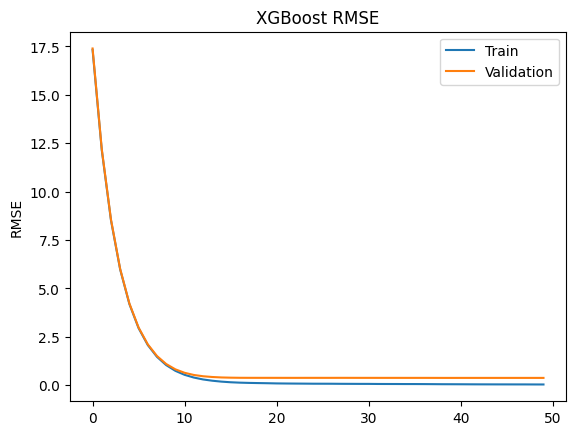

In [17]:
param = {
'base_score':0.5, 'booster':'gbtree', 'colsample_bylevel':1,
'colsample_bynode':1, 'colsample_bytree':1, 'gamma':0, 'gpu_id':-1,
'importance_type':'gain', 'interaction_constraints':'',
'learning_rate':0.3, 'max_delta_step':0, 'max_depth':6,
'min_child_weight':1, 'monotone_constraints':(),
'n_estimators':100, 'n_jobs':0, 'num_parallel_tree':1, 'random_state':0,
'reg_alpha':0, 'reg_lambda':1, 'scale_pos_weight':1, 'subsample':1,
'tree_method':'exact', 'validate_parameters':1, 'verbosity':None
}

output_folder = '../training/xgb_holdout/'

xr = CDMSXGBRegressor()
xr.read_dataset('../data/reduced_dataset/reduced_data.csv', HOS=[-12.502, -29.500, -41.900])
xr.preprocess_dataset()
xr.initialize_xgb_regressors(param)
xr.train_regressors(output_folder)
xr.get_predictions(output_folder)

Since, we had set `early_stopping_rounds`, we see that the training stops before it reaches 50 iterations as the validation scores don't improve.
Nevertheless, we can see that there is a slight overtraining as the training RMSE is btter than the validation RMSE. Next, we will try to see how the performance is on a holdout datasets. We can also avoid overtraining by setting the gamma and regularization terms to `'gamma':40, 'reg_alpha':1, 'reg_lambda':1`.

Training regressors...
[0]	validation_0-rmse:17.30662	validation_1-rmse:17.46165
[1]	validation_0-rmse:12.14680	validation_1-rmse:12.26931
[2]	validation_0-rmse:8.53511	validation_1-rmse:8.63146
[3]	validation_0-rmse:6.01174	validation_1-rmse:6.08346
[4]	validation_0-rmse:4.24893	validation_1-rmse:4.31517
[5]	validation_0-rmse:3.02437	validation_1-rmse:3.08326
[6]	validation_0-rmse:2.17577	validation_1-rmse:2.22850
[7]	validation_0-rmse:1.59243	validation_1-rmse:1.63955
[8]	validation_0-rmse:1.16889	validation_1-rmse:1.21078
[9]	validation_0-rmse:0.89092	validation_1-rmse:0.92633
[10]	validation_0-rmse:0.71451	validation_1-rmse:0.74674
[11]	validation_0-rmse:0.61306	validation_1-rmse:0.64408
[12]	validation_0-rmse:0.55206	validation_1-rmse:0.58158
[13]	validation_0-rmse:0.52333	validation_1-rmse:0.55273
[14]	validation_0-rmse:0.50694	validation_1-rmse:0.53614
[15]	validation_0-rmse:0.50212	validation_1-rmse:0.53108
[16]	validation_0-rmse:0.49973	validation_1-rmse:0.52848
[17]	validatio

/opt/homebrew/anaconda3/envs/tf-metal/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/opt/homebrew/anaconda3/envs/tf-metal/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[47]	validation_0-rmse:0.49742	validation_1-rmse:0.52547
[48]	validation_0-rmse:0.49742	validation_1-rmse:0.52547
[49]	validation_0-rmse:0.49742	validation_1-rmse:0.52547
[50]	validation_0-rmse:0.49742	validation_1-rmse:0.52547
Train RMSE:  0.49741832093346916
Validation RMSE:  0.5253842614583158
Test RMSE:  4.044156140613134


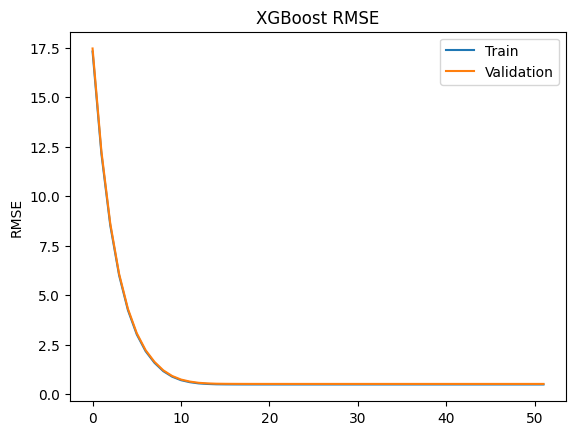

In [7]:
param = {
'base_score':0.5, 'booster':'gbtree', 'colsample_bylevel':1,
'colsample_bynode':1, 'colsample_bytree':1, 'gamma':40, 'gpu_id':-1,
'importance_type':'gain', 'interaction_constraints':'',
'learning_rate':0.3, 'max_delta_step':0, 'max_depth':3,
'min_child_weight':1, 'monotone_constraints':(),
'n_estimators':100, 'n_jobs':0, 'num_parallel_tree':1, 'random_state':0,
'reg_alpha':1, 'reg_lambda':1, 'scale_pos_weight':1, 'subsample':1,
'tree_method':'exact', 'validate_parameters':1, 'verbosity':None
}

output_folder = '../training/xgb_holdout_reg/'

xr = CDMSXGBRegressor()
xr.read_dataset('../data/reduced_dataset/reduced_data.csv', HOS=[-12.502, -29.500, -41.900])
xr.preprocess_dataset()
xr.initialize_xgb_regressors(param)
xr.train_regressors(output_folder)
xr.get_predictions(output_folder)

In this training, we avoid overfitting, but as we see from the `Test RMSE` of the holdout dataset, it doesn't perform on the `y` values that are not provided to the model during training.

Next, we check the variable ranking of the variables using the `fscores()` method to check which features provide the most gain after splitting.

In [10]:
feature_map = dict([('f'+str(iv),v) for iv, v in enumerate(xr.df.drop(['predictions','y','HOS', 'cv'], axis=1).columns)])
for k, v in xr.xgb_regressors[0].get_booster().get_fscore().items():
    print(feature_map[k],'  \t', v)

PBstart   	 13.0
PCstart   	 24.0
PDstart   	 10.0
PFstart   	 5.0
PArise   	 8.0
PBrise   	 4.0
PCrise   	 3.0
PFrise   	 4.0
PAwidth   	 1.0
PBwidth   	 4.0


Next, we can create some visuals to see how the individual learners are built. We will get the first tree from the booster using `get_dump()` method and then plot it's structure using `graphviz` package.

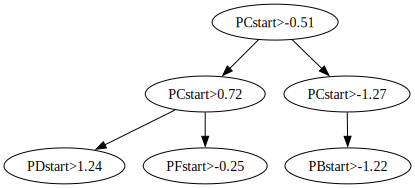

In [13]:
xgb_dump = xr.xgb_regressors[0].get_booster().trees_to_dataframe()
dot = Digraph()
tree_dump = xgb_dump[xgb_dump['Tree']==0]
for inode, node in tree_dump.iterrows():
    if node.Feature == 'Leaf': continue
    feature_name = feature_map[node.Feature]
    split = round(node.Split, 2)
    node_text = feature_name + '>' + str(split)
    if inode==0: dot.node(node_text)
    if node.No != 'NaN':
        child_node = tree_dump[tree_dump['ID']==node.No]
        child_feature_name = child_node.Feature.values[0]
        if child_feature_name == 'Leaf':
            child_node_text = 'Leaf'
        else:
            child_node_split = round(child_node.Split.values[0], 2)
            child_node_text = feature_map[child_feature_name] + '>' + str(child_node_split)
            dot.node(child_node_text)
            dot.edge(node_text, child_node_text)
    if node.Yes != 'NaN':
        child_node = tree_dump[tree_dump['ID']==node.Yes]
        child_feature_name = child_node.Feature.values[0]
        if child_feature_name == 'Leaf':
            child_node_text = 'Leaf'
        else:
            child_node_split = round(child_node.Split.values[0], 2)
            child_node_text = feature_map[child_feature_name] + '>' + str(child_node_split)
            dot.node(child_node_text)
            dot.edge(node_text, child_node_text)

dot

We can seen in the above figure that "PCstart" is used 3 times in the first tree, followed by "PBstart", "PDstart" and "PFstart". This is consistent with what we got from the fscores. One can check the tree structure for other learners as well, but "PCstart" is indeed the most important feature.

Training regressors...
[0]	validation_0-rmse:17.28396	validation_1-rmse:17.49451
[1]	validation_0-rmse:12.13100	validation_1-rmse:12.27925
[2]	validation_0-rmse:8.52411	validation_1-rmse:8.62494
[3]	validation_0-rmse:6.00468	validation_1-rmse:6.08463
[4]	validation_0-rmse:4.24262	validation_1-rmse:4.29669
[5]	validation_0-rmse:3.01425	validation_1-rmse:3.05601
[6]	validation_0-rmse:2.16538	validation_1-rmse:2.19918
[7]	validation_0-rmse:1.57638	validation_1-rmse:1.60852
[8]	validation_0-rmse:1.18218	validation_1-rmse:1.21559
[9]	validation_0-rmse:0.90840	validation_1-rmse:0.93825
[10]	validation_0-rmse:0.73633	validation_1-rmse:0.76735
[11]	validation_0-rmse:0.61698	validation_1-rmse:0.65203
[12]	validation_0-rmse:0.55355	validation_1-rmse:0.59110
[13]	validation_0-rmse:0.51829	validation_1-rmse:0.55791
[14]	validation_0-rmse:0.50134	validation_1-rmse:0.54162
[15]	validation_0-rmse:0.49649	validation_1-rmse:0.53739
[16]	validation_0-rmse:0.49409	validation_1-rmse:0.53535
[17]	validatio

/opt/homebrew/anaconda3/envs/tf-metal/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/opt/homebrew/anaconda3/envs/tf-metal/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[20]	validation_0-rmse:0.49190	validation_1-rmse:0.53365
[21]	validation_0-rmse:0.49183	validation_1-rmse:0.53362
[22]	validation_0-rmse:0.49180	validation_1-rmse:0.53361
[23]	validation_0-rmse:0.49178	validation_1-rmse:0.53361
[24]	validation_0-rmse:0.49177	validation_1-rmse:0.53361
[25]	validation_0-rmse:0.49177	validation_1-rmse:0.53362
[26]	validation_0-rmse:0.49176	validation_1-rmse:0.53362
[27]	validation_0-rmse:0.49176	validation_1-rmse:0.53362
[28]	validation_0-rmse:0.49176	validation_1-rmse:0.53362
Train RMSE:  0.4917605130137525
Validation RMSE:  0.53360971101086
Test rmse:  4.332116143660782


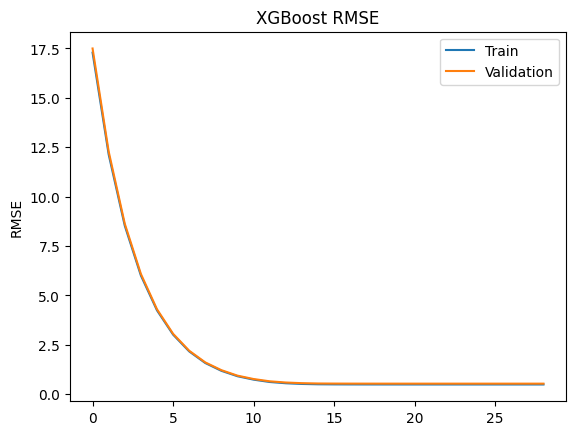

In [18]:
param = {
'base_score':0.5, 'booster':'gbtree', 'colsample_bylevel':1,
'colsample_bynode':1, 'colsample_bytree':1, 'gamma':40, 'gpu_id':-1,
'importance_type':'gain', 'interaction_constraints':'',
'learning_rate':0.3, 'max_delta_step':0, 'max_depth':3,
'min_child_weight':1, 'monotone_constraints':(),
'n_estimators':100, 'n_jobs':0, 'num_parallel_tree':1, 'random_state':0,
'reg_alpha':1, 'reg_lambda':1, 'scale_pos_weight':1, 'subsample':1,
'tree_method':'exact', 'validate_parameters':1, 'verbosity':None
}

#['Row','PCstart','PDstart','PFstart','PCrise','PDrise']
output_folder = '../training/CDMS_XGBoost_FAIR_smear_0_02'
xr = CDMSXGBRegressor()
xr.read_dataset('../data/processed_csv/hos_reduced_data_smear_0_02.csv')
xr.preprocess_dataset()
xr.initialize_xgb_regressors(param)
xr.train_regressors(output_folder)
xr.get_predictions(output_folder)

df = pd.read_csv('../data/reduced_dataset/reduced_data.csv')
df['HOS'] = df['y'].apply(lambda x: True if x in [-12.502, -29.500, -41.900] else False)

# ['Row','PCstart','PDstart','PFstart','PCrise','PDrise','y','HOS']
df.head()
Y_hos = df[df['HOS']==True]['y'].to_numpy()
X_hos = df[df['HOS']==True].drop(['Row','y','HOS'], axis=1).to_numpy()

X_hos = xr.scaler.transform(X_hos)
pred_hos_values = None
pred_hos_values = xr.xgb_regressors[0].predict(X_hos)

dy = pred_hos_values-Y_hos
print('Test rmse: ', np.std(dy))

Training regressors...
[0]	validation_0-rmse:17.39066	validation_1-rmse:17.36293
[1]	validation_0-rmse:12.22521	validation_1-rmse:12.17548
[2]	validation_0-rmse:8.61831	validation_1-rmse:8.57345
[3]	validation_0-rmse:6.11027	validation_1-rmse:6.05816
[4]	validation_0-rmse:4.37116	validation_1-rmse:4.33204
[5]	validation_0-rmse:3.17885	validation_1-rmse:3.15194
[6]	validation_0-rmse:2.38339	validation_1-rmse:2.37244
[7]	validation_0-rmse:1.86017	validation_1-rmse:1.86086
[8]	validation_0-rmse:1.52184	validation_1-rmse:1.54596
[9]	validation_0-rmse:1.32974	validation_1-rmse:1.36826
[10]	validation_0-rmse:1.20830	validation_1-rmse:1.26463
[11]	validation_0-rmse:1.14846	validation_1-rmse:1.21998
[12]	validation_0-rmse:1.11508	validation_1-rmse:1.19701
[13]	validation_0-rmse:1.09772	validation_1-rmse:1.18094
[14]	validation_0-rmse:1.09013	validation_1-rmse:1.17579
[15]	validation_0-rmse:1.08790	validation_1-rmse:1.17464
[16]	validation_0-rmse:1.08681	validation_1-rmse:1.17426
[17]	validatio

/opt/homebrew/anaconda3/envs/tf-metal/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/opt/homebrew/anaconda3/envs/tf-metal/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Train RMSE:  1.0857450385001868
Validation RMSE:  1.1742104630904187
Test rmse:  4.521970455792957


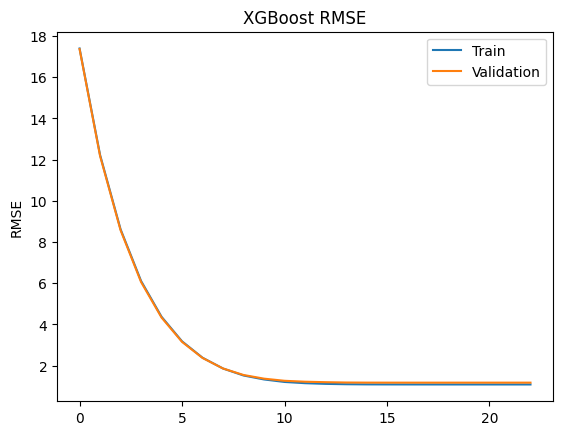

In [19]:
param = {
'base_score':0.5, 'booster':'gbtree', 'colsample_bylevel':1,
'colsample_bynode':1, 'colsample_bytree':1, 'gamma':40, 'gpu_id':-1,
'importance_type':'gain', 'interaction_constraints':'',
'learning_rate':0.3, 'max_delta_step':0, 'max_depth':3,
'min_child_weight':1, 'monotone_constraints':(),
'n_estimators':100, 'n_jobs':0, 'num_parallel_tree':1, 'random_state':0,
'reg_alpha':1, 'reg_lambda':1, 'scale_pos_weight':1, 'subsample':1,
'tree_method':'exact', 'validate_parameters':1, 'verbosity':None
}

#['Row','PCstart','PDstart','PFstart','PCrise','PDrise']
output_folder = '../training/CDMS_XGBoost_FAIR_smear_1_0'
xr = CDMSXGBRegressor()
xr.read_dataset('../data/processed_csv/hos_reduced_data_smear_1_0.csv')
xr.preprocess_dataset()
xr.initialize_xgb_regressors(param)
xr.train_regressors(output_folder)
xr.get_predictions(output_folder)

df = pd.read_csv('../data/reduced_dataset/reduced_data.csv')
df['HOS'] = df['y'].apply(lambda x: True if x in [-12.502, -29.500, -41.900] else False)

# ['Row','PCstart','PDstart','PFstart','PCrise','PDrise','y','HOS']
df.head()
Y_hos = df[df['HOS']==True]['y'].to_numpy()
X_hos = df[df['HOS']==True].drop(['Row','y','HOS'], axis=1).to_numpy()

X_hos = xr.scaler.transform(X_hos)
pred_hos_values = None
pred_hos_values = xr.xgb_regressors[0].predict(X_hos)

dy = pred_hos_values-Y_hos
print('Test rmse: ', np.std(dy))

Training regressors...
[0]	validation_0-rmse:17.86305	validation_1-rmse:17.62661
[1]	validation_0-rmse:12.83848	validation_1-rmse:12.72378
[2]	validation_0-rmse:9.43342	validation_1-rmse:9.40494
[3]	validation_0-rmse:7.18609	validation_1-rmse:7.23107
[4]	validation_0-rmse:5.76232	validation_1-rmse:5.85458
[5]	validation_0-rmse:4.90751	validation_1-rmse:5.04308
[6]	validation_0-rmse:4.41658	validation_1-rmse:4.58801
[7]	validation_0-rmse:4.14689	validation_1-rmse:4.34524
[8]	validation_0-rmse:4.00018	validation_1-rmse:4.22064
[9]	validation_0-rmse:3.91455	validation_1-rmse:4.15133
[10]	validation_0-rmse:3.86630	validation_1-rmse:4.11703
[11]	validation_0-rmse:3.83836	validation_1-rmse:4.10304
[12]	validation_0-rmse:3.82098	validation_1-rmse:4.08961
[13]	validation_0-rmse:3.80462	validation_1-rmse:4.08524
[14]	validation_0-rmse:3.79470	validation_1-rmse:4.07756
[15]	validation_0-rmse:3.78275	validation_1-rmse:4.07669
[16]	validation_0-rmse:3.77845	validation_1-rmse:4.07614
[17]	validatio

/opt/homebrew/anaconda3/envs/tf-metal/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/opt/homebrew/anaconda3/envs/tf-metal/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Train RMSE:  3.728253791236527
Validation RMSE:  4.072205377533893
Test rmse:  3.6946739828345425


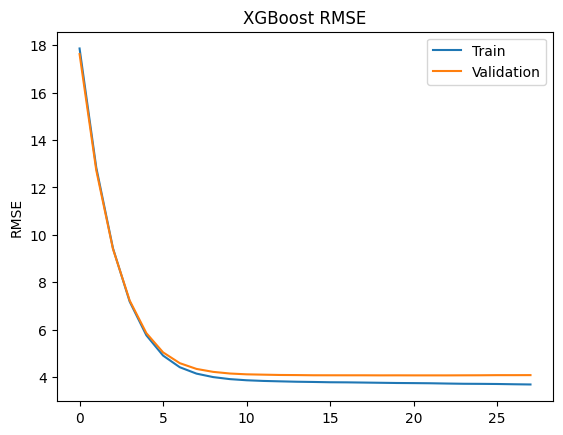

In [20]:
param = {
'base_score':0.5, 'booster':'gbtree', 'colsample_bylevel':1,
'colsample_bynode':1, 'colsample_bytree':1, 'gamma':40, 'gpu_id':-1,
'importance_type':'gain', 'interaction_constraints':'',
'learning_rate':0.3, 'max_delta_step':0, 'max_depth':3,
'min_child_weight':1, 'monotone_constraints':(),
'n_estimators':100, 'n_jobs':0, 'num_parallel_tree':1, 'random_state':0,
'reg_alpha':1, 'reg_lambda':1, 'scale_pos_weight':1, 'subsample':1,
'tree_method':'exact', 'validate_parameters':1, 'verbosity':None
}

#['Row','PCstart','PDstart','PFstart','PCrise','PDrise']
output_folder = '../training/CDMS_XGBoost_FAIR_smear_4_0'
xr = CDMSXGBRegressor()
xr.read_dataset('../data/processed_csv/hos_reduced_data_smear_4_0.csv')
xr.preprocess_dataset()
xr.initialize_xgb_regressors(param)
xr.train_regressors(output_folder)
xr.get_predictions(output_folder)

df = pd.read_csv('../data/reduced_dataset/reduced_data.csv')
df['HOS'] = df['y'].apply(lambda x: True if x in [-12.502, -29.500, -41.900] else False)

# ['Row','PCstart','PDstart','PFstart','PCrise','PDrise','y','HOS']
df.head()
Y_hos = df[df['HOS']==True]['y'].to_numpy()
X_hos = df[df['HOS']==True].drop(['Row','y','HOS'], axis=1).to_numpy()

X_hos = xr.scaler.transform(X_hos)
pred_hos_values = None
pred_hos_values = xr.xgb_regressors[0].predict(X_hos)

dy = pred_hos_values-Y_hos
print('Test rmse: ', np.std(dy))